<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [223]:
import pandas as pd

In [224]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [225]:
df.to_csv('hw_5_data.csv')

In [226]:
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

In [227]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [228]:
# заменил тип данных у процента удаленки на категориальный
df = df.astype({'remote_ratio': 'int32'})

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [229]:
category_cols = ['experience_level', 'employment_type', 'company_size', 'remote_ratio']
values_dict = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'],
    'employment_type': ['FT', 'PT', 'CT', 'FL'],
    'company_size': ['S', 'M', 'L'],
    'remote_ratio': [0, 50, 100]
}

In [230]:
for column in category_cols:
  for value in df[column]:
    if value not in values_dict[column]:
      print(f'в столбце {column} есть некорректное значение {value}')

некорректных значений нет

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

**Описательных хар-ки**

In [231]:
df.describe()
# данные адекватны: нет отрицательных значений, цифры соотвествуют адекватным нормам

work_year        salary  salary_in_usd  remote_ratio
count  3755.000000  3.755000e+03    3755.000000   3755.000000
mean   2022.373635  1.906956e+05  137570.389880     46.271638
std       0.691448  6.716765e+05   63055.625278     48.589050
min    2020.000000  6.000000e+03    5132.000000      0.000000
25%    2022.000000  1.000000e+05   95000.000000      0.000000
50%    2022.000000  1.380000e+05  135000.000000      0.000000
75%    2023.000000  1.800000e+05  175000.000000    100.000000
max    2023.000000  3.040000e+07  450000.000000    100.000000

In [232]:
df.describe(include='object')

experience_level employment_type      job_title salary_currency  \
count              3755            3755           3755            3755   
unique                4               4             93              20   
top                  SE              FT  Data Engineer             USD   
freq               2516            3718           1040            3224   

       employee_residence company_location company_size  
count                3755             3755         3755  
unique                 78               72            3  
top                    US               US            M  
freq                 3004             3040         3153

**Пропуски**

In [233]:
df.isna().sum()
# пропусков нет

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [234]:
# можно удалить столбец salary, так как есть в долларах
df = df.drop(columns = ['salary'])

In [235]:
df = df.drop(columns = ['salary_currency'])

**Ваши выводы здесь**

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [236]:
from sklearn.model_selection import train_test_split

In [237]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')

In [238]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['salary_in_usd']), df['salary_in_usd'], test_size=0.2, random_state=42)

In [239]:
X_train.shape

(3004, 8)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [240]:
df.head(1)

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   

   salary_in_usd employee_residence  remote_ratio company_location  \
0          85847                 ES           100               ES   

  company_size  
0            L

In [241]:
num_cols=['work_year', 'salary_in_usd']

In [242]:
# непрерывный признак + таргет
num_df = df[num_cols]
num_df.head(1)

work_year  salary_in_usd
0       2023          85847

In [243]:
# разбиение непрерывного
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(num_df.drop(columns=['salary_in_usd']), num_df['salary_in_usd'], test_size=0.2, random_state=42)

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [244]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import sklearn
import numpy as np

In [245]:
model_lin_reg = LinearRegression()

model_lin_reg.fit(X_num_train, y_num_train)

y_pred = model_lin_reg.predict(X_num_test)

In [246]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_num_test, y_pred)

0.7064709508683961

In [247]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

61358.082035949934

**Закономерно по одному признаку качество ужасное**

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [248]:
from catboost import CatBoostRegressor

In [249]:
model_cat_boost = CatBoostRegressor(random_seed=42, verbose=0)
model_cat_boost.fit(X_num_train, y_num_train)

y_pred = model_cat_boost.predict(X_num_test)

In [250]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_num_test, y_pred)

0.7065535789950731

In [251]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

61617.13415718041

**Очень похоже и потому также плохо**

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

**1 подход**

In [252]:
X_categorical_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

In [253]:
from sklearn.preprocessing import OneHotEncoder

In [254]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(X_train[X_categorical_cols])

encoded_categorical_df = pd.DataFrame(
    encoded_categorical,
    columns=encoder.get_feature_names_out(X_categorical_cols)
)

X_train_encoded_ohe = pd.concat([X_train['work_year'].reset_index(), encoded_categorical_df], axis=1).drop(columns=['index'])

In [255]:
encoded_categorical = encoder.transform(X_test[X_categorical_cols])

encoded_categorical_df = pd.DataFrame(
    encoded_categorical,
    columns=encoder.get_feature_names_out(X_categorical_cols)
)

X_test_encoded_ohe = pd.concat([X_test['work_year'].reset_index(), encoded_categorical_df], axis=1).drop(columns=['index'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [256]:
# Бустинг
model_cat_boost = CatBoostRegressor(random_seed=42, verbose=0)
model_cat_boost.fit(X_train_encoded_ohe, y_train)

y_pred = model_cat_boost.predict(X_test_encoded_ohe)

In [257]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.3634634712642949

In [258]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

48430.76138862407

In [259]:
# Линенйная регрессия
model_lin_reg = LinearRegression()

model_lin_reg.fit(X_train_encoded_ohe, y_train)

y_pred = model_lin_reg.predict(X_test_encoded_ohe)

In [260]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.40340867305813466

In [261]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

49802.04635511091

**2 подход**

In [262]:
from sklearn.preprocessing import OrdinalEncoder

In [263]:
X_categorical_cols

['experience_level',
 'employment_type',
 'job_title',
 'employee_residence',
 'remote_ratio',
 'company_location',
 'company_size']

In [264]:
# Инициализация и обучение на обучающих данных
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_encoder.fit(X_train[X_categorical_cols])

# Преобразование обучающих и тестовых данных
encoded_labe_train = ordinal_encoder.transform(X_train[X_categorical_cols])
encoded_labe_test = ordinal_encoder.transform(X_test[X_categorical_cols])

encoded_labe_train_df = pd.DataFrame(
    encoded_labe_train,
    columns=X_categorical_cols
)

encoded_labe_test_df = pd.DataFrame(
    encoded_labe_test,
    columns=X_categorical_cols
)

X_train_encoded_labe = pd.concat([X_train['work_year'].reset_index(), encoded_labe_train_df], axis=1).drop(columns=['index'])
X_test_encoded_labe = pd.concat([X_test['work_year'].reset_index(), encoded_labe_test_df], axis=1).drop(columns=['index'])

In [265]:
X_train_encoded_labe.head(3)

work_year  experience_level  employment_type  job_title  \
0       2022               3.0              2.0       31.0   
1       2023               2.0              2.0       82.0   
2       2022               3.0              2.0       23.0   

   employee_residence  remote_ratio  company_location  company_size  
0                24.0           0.0              23.0           1.0  
1                71.0           2.0              66.0           1.0  
2                71.0           0.0              66.0           1.0

In [266]:
# Бустинг
model_cat_boost = CatBoostRegressor(random_seed=42, verbose=0)
model_cat_boost.fit(X_train_encoded_labe, y_train)

y_pred = model_cat_boost.predict(X_test_encoded_labe)

In [267]:
# MAPE
mean_absolute_percentage_error(y_test, y_pred)

0.41671354529221366

In [268]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

48835.49280449569

In [269]:
# Линенйная регрессия
model_lin_reg = LinearRegression()

model_lin_reg.fit(X_train_encoded_labe, y_train)

y_pred = model_lin_reg.predict(X_test_encoded_labe)

In [270]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.49727770945882815

In [271]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

53263.35030903578

**3 подход**

In [272]:
from category_encoders import TargetEncoder

In [273]:
X_train = X_train.astype({'remote_ratio': 'object'})
X_test = X_test.astype({'remote_ratio': 'object'})

In [274]:
encoder = TargetEncoder()

X_train_encoded_mte_df = encoder.fit_transform(X_train[X_categorical_cols], y_train)

X_test_encoded_mte_df = encoder.transform(X_test[X_categorical_cols])

X_train_encoded_mte = pd.concat([X_train['work_year'].reset_index(), X_train_encoded_mte_df.reset_index()], axis=1).drop(columns=['index'])
X_test_encoded_mte = pd.concat([X_test['work_year'].reset_index(), X_test_encoded_mte_df.reset_index()], axis=1).drop(columns=['index'])

In [275]:
X_train_encoded_mte.head(3)

work_year  experience_level  employment_type      job_title  \
0       2022     153656.470179    138820.514968  143884.887707   
1       2023     103665.592593    138820.514968  166127.214714   
2       2022     153656.470179    138820.514968  108194.875000   

   employee_residence   remote_ratio  company_location  company_size  
0        64543.740300  144484.290046      62483.779941  143568.31458  
1       153074.004141  137943.723596     152095.587971  143568.31458  
2       153074.004141  144484.290046     152095.587971  143568.31458

In [276]:
# Бустинг
model_cat_boost = CatBoostRegressor(random_seed=42, verbose=0)
model_cat_boost.fit(X_train_encoded_mte, y_train)

y_pred = model_cat_boost.predict(X_test_encoded_mte)

In [277]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.4220115835637701

In [278]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

48409.358784949545

In [279]:
# Линенйная регрессия
model_lin_reg = LinearRegression()

model_lin_reg.fit(X_train_encoded_mte, y_train)

y_pred = model_lin_reg.predict(X_test_encoded_mte)

In [280]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.39280339583750584

In [281]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

48862.72159413691

Лучшей предобработкой по качеству для Бустинга стала OHE \
Лучшей предобработкой по качеству для Линейной регрессии стала MeanTargetEncoding

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [282]:
# Линейная регрессия при MeanTargetEncoding

# абсолютная ошибка
errors = abs(y_pred - y_test)

X_test['error_model_3'] = errors

# Сортировка
X_test.sort_values(by='error_model_3', ascending=False).head(20)

work_year experience_level employment_type                   job_title  \
1288       2023               SE              FT                Data Analyst   
2359       2022               SE              FT      Data Science Tech Lead   
1105       2023               SE              FT              Data Scientist   
33         2023               SE              FT    Computer Vision Engineer   
478        2023               EX              FT    Director of Data Science   
1116       2023               SE              FT   Machine Learning Engineer   
3609       2020               SE              FT  Machine Learning Scientist   
325        2023               MI              FT   Machine Learning Engineer   
183        2020               EX              FT          Staff Data Analyst   
3582       2021               SE              FT          Lead Data Engineer   
1677       2023               SE              FT              Data Scientist   
1593       2023               SE              FT               Data Engineer   
3387       2022               SE              FT               Data Engineer   
358        2023               SE              FT   Machine Learning Engineer   
254        2023               SE              FT           Research Engineer   
1187       2023               SE              FT   Machine Learning Engineer   
1488       2023               SE              FT              Data Scientist   
549        2023               SE              FT              Data Scientist   
3037       2022               SE              FT              Data Architect   
461        2023               SE              FT              Data Scientist   

     employee_residence remote_ratio company_location company_size  \
1288                 US            0               US            M   
2359                 US           50               US            L   
1105                 US            0               US            M   
33                   US            0               US            M   
478                  US            0               US            M   
1116                 US            0               US            M   
3609                 JP            0               JP            S   
325                  US          100               US            M   
183                  NG            0               CA            M   
3582                 US            0               US            L   
1677                 US          100               US            M   
1593                 US            0               US            M   
3387                 US          100               US            M   
358                  US          100               US            M   
254                  US            0               US            M   
1187                 US          100               US            M   
1488                 US          100               US            M   
549                  US          100               US            M   
3037                 US            0               US            M   
461                  CA            0               CA            M   

      error_model_3  
1288  253172.874591  
2359  230791.724941  
1105  207481.483633  
33    187106.961194  
478   158114.345269  
1116  151040.033819  
3609  140687.210767  
325   139110.443882  
183   138234.580635  
3582  136600.681491  
1677  135347.578738  
1593  134946.101208  
3387  134630.676991  
358   132306.128924  
254   117548.342456  
1187  116306.128924  
1488  113347.578738  
549   113347.578738  
3037  112200.562569  
461   111974.690397

**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

Попробуем закодировать название должности по ключевым словам ANALYST, SCIENCIST, RESEARCHER, ENGINEER и т.д.

In [283]:
X_train_new_feature = X_train.copy()
X_test_new_feature = X_test.copy()

In [284]:
X_train_new_feature.head()

work_year experience_level employment_type           job_title  \
2238       2022               SE              FT       Data Engineer   
485        2023               MI              FT  Research Scientist   
2177       2022               SE              FT        Data Analyst   
3305       2022               SE              FT       Data Engineer   
1769       2023               SE              FT       Data Engineer   

     employee_residence remote_ratio company_location company_size  
2238                 ES            0               ES            M  
485                  US          100               US            M  
2177                 US            0               US            M  
3305                 US          100               US            M  
1769                 US          100               US            M

In [285]:
X_train_new_feature.job_title.unique()

array(['Data Engineer', 'Research Scientist', 'Data Analyst',
       'Data Scientist', 'Data Science Consultant',
       'Computer Vision Engineer', 'Machine Learning Engineer',
       'Analytics Engineer', 'Data Architect',
       'Applied Machine Learning Scientist',
       'Computer Vision Software Engineer', 'Data Manager',
       'Applied Scientist', 'Machine Learning Researcher',
       'Business Intelligence Engineer', '3D Computer Vision Researcher',
       'BI Developer', 'Machine Learning Developer',
       'Cloud Database Engineer', 'Data Science Manager',
       'Research Engineer', 'AI Scientist',
       'Machine Learning Software Engineer', 'Machine Learning Scientist',
       'ML Engineer', 'Business Data Analyst', 'Data Operations Engineer',
       'Head of Machine Learning', 'AI Developer', 'NLP Engineer',
       'Azure Data Engineer', 'BI Data Analyst', 'Big Data Engineer',
       'Deep Learning Engineer', 'Data Quality Analyst',
       'Principal Data Analyst', 'Head

Флаги будем ставить для следующих слов: Analyst, Scientist, Engineer, Researcher, Developer, BI

In [286]:
words_to_find = ['Analyst', 'Scientist', 'Engineer', 'Researcher', 'Developer', 'BI', 'Manager', 'Architect']

In [287]:
def categorize_job_name(row):
    found_words = [word for word in words_to_find if word in row]
    if len(found_words) == 0:
        return 'unknown'
    else:
        return found_words[0]

In [288]:
X_train_new_feature['name_job_category'] = X_train_new_feature['job_title'].apply(categorize_job_name)
X_test_new_feature['name_job_category'] = X_test_new_feature['job_title'].apply(categorize_job_name)

In [289]:
X_train_new_feature.head()

work_year experience_level employment_type           job_title  \
2238       2022               SE              FT       Data Engineer   
485        2023               MI              FT  Research Scientist   
2177       2022               SE              FT        Data Analyst   
3305       2022               SE              FT       Data Engineer   
1769       2023               SE              FT       Data Engineer   

     employee_residence remote_ratio company_location company_size  \
2238                 ES            0               ES            M   
485                  US          100               US            M   
2177                 US            0               US            M   
3305                 US          100               US            M   
1769                 US          100               US            M   

     name_job_category  
2238          Engineer  
485          Scientist  
2177           Analyst  
3305          Engineer  
1769          Engineer

In [290]:
X_train_new_feature.query('name_job_category == "unknown"')

work_year experience_level employment_type                 job_title  \
2115       2022               MI              FT   Data Science Consultant   
3192       2022               EX              FT  Head of Machine Learning   
812        2023               MI              FT   Data Science Consultant   
3311       2022               EX              FT      Head of Data Science   
3436       2021               SE              FT              Head of Data   
...         ...              ...             ...                       ...   
2572       2022               SE              FT         Data Science Lead   
3561       2021               EN              FT   Data Science Consultant   
2747       2022               EN              FT           Data Specialist   
3444       2022               MI              FT              Head of Data   
3092       2022               SE              FT           Data Specialist   

     employee_residence remote_ratio company_location company_size  \
2115                 GB            0               GB            M   
3192                 IN           50               IN            L   
812                  US            0               US            M   
3311                 US          100               US            M   
3436                 SI          100               SI            L   
...                 ...          ...              ...          ...   
2572                 US           50               US            S   
3561                 DE          100               DE            S   
2747                 CL          100               US            L   
3444                 EE          100               EE            S   
3092                 US          100               US            L   

     name_job_category  
2115           unknown  
3192           unknown  
812            unknown  
3311           unknown  
3436           unknown  
...                ...  
2572           unknown  
3561           unknown  
2747           unknown  
3444           unknown  
3092           unknown  

[72 rows x 9 columns]

In [291]:
X_categorical_cols_new_feat = X_categorical_cols.copy()
X_categorical_cols_new_feat.append('name_job_category')
X_categorical_cols_new_feat

['experience_level',
 'employment_type',
 'job_title',
 'employee_residence',
 'remote_ratio',
 'company_location',
 'company_size',
 'name_job_category']

In [292]:
# Применим TargetEncoding
X_categorical_cols_new_feat = X_categorical_cols.copy()
X_categorical_cols_new_feat.append(words_to_find)


encoder_new_feat = TargetEncoder()

X_train_new_feat_encoded_mte_df = encoder_new_feat.fit_transform(X_train_new_feature[['experience_level', 'employment_type', 'employee_residence', 'remote_ratio',
 'company_location',
 'company_size',
 'name_job_category']], y_train)

X_test_new_feat_encoded_mte_df = encoder_new_feat.transform(X_test_new_feature[['experience_level', 'employment_type', 'employee_residence', 'remote_ratio',
 'company_location',
 'company_size',
 'name_job_category']])

X_train_new_feat_encoded_mte = pd.concat([X_train['work_year'].reset_index(), X_train_new_feat_encoded_mte_df.reset_index()], axis=1).drop(columns=['index'])
X_test_new_feat_encoded_mte = pd.concat([X_test['work_year'].reset_index(), X_test_new_feat_encoded_mte_df.reset_index()], axis=1).drop(columns=['index'])

In [293]:
# Обучим
# Бустинг
model_cat_boost = CatBoostRegressor(random_seed=42, verbose=0)
model_cat_boost.fit(X_train_new_feat_encoded_mte, y_train)

y_pred = model_cat_boost.predict(X_test_new_feat_encoded_mte)

In [294]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.443605945120783

In [295]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

49986.628376879686

In [296]:
# Линенйная регрессия
model_lin_reg = LinearRegression()

model_lin_reg.fit(X_train_new_feat_encoded_mte, y_train)

y_pred = model_lin_reg.predict(X_test_new_feat_encoded_mte)

In [297]:
# MAPE
sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

0.3989138663440934

In [298]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

49331.029655736966

**Качество стало чуть хуже, но сам признак стал значительно проще - вместо целого названия должности теперь одна из 9 категорий**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [299]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import time

In [300]:
# Pool для CatBoost
train_pool = Pool(X_train_encoded_mte, y_train)
test_pool = Pool(X_test_encoded_mte, y_test)

# CatBoostRegressor
cbr = CatBoostRegressor(
    iterations=1000,  # Количество итераций
    learning_rate=0.1,  # Скорость обучения
    depth=6,  # Глубина дерева
    loss_function='RMSE',  # Функция потерь
    eval_metric='RMSE',  # Метрика для оценки
    random_seed=42,
    verbose=100  # Вывод лога каждые 100 итераций
)

# время обучения
start_time = time.time()
cbr.fit(train_pool)
training_time = time.time() - start_time
print(f"Время обучения: {training_time:.2f} секунд")

# время обучения
start_time = time.time()
y_pred = cbr.predict(test_pool)
prediction_time = time.time() - start_time
print(f"Время предсказания: {prediction_time:.2f} секунд")

# качество модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Коэффициент детерминации (R^2): {r2:.4f}")

# Подбор
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [500, 1000, 1500]
}

grid_search = GridSearchCV(estimator=cbr, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error')

# время поиска гиперпараметров
start_time = time.time()
grid_search.fit(X_train_encoded_mte, y_train)
grid_search_time = time.time() - start_time
print(f"Время подбора гиперпараметров: {grid_search_time:.2f} секунд")

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# качество модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(test_pool)
rmse_best = (mean_squared_error(y_test, y_pred_best))**0.5
r2_best = r2_score(y_test, y_pred_best)
print(f"Среднеквадратичная ошибка (RMSE) с лучшими параметрами: {rmse_best:.4f}")
print(f"Коэффициент детерминации (R^2) с лучшими параметрами: {r2_best:.4f}")

0:	learn: 60716.0443475	total: 719us	remaining: 719ms
100:	learn: 44441.1242864	total: 45.4ms	remaining: 405ms
200:	learn: 42804.7035662	total: 90.8ms	remaining: 361ms
300:	learn: 41913.7171109	total: 135ms	remaining: 314ms
400:	learn: 41346.1683077	total: 181ms	remaining: 270ms
500:	learn: 40990.8258277	total: 226ms	remaining: 225ms
600:	learn: 40726.1371822	total: 270ms	remaining: 179ms
700:	learn: 40535.6327130	total: 315ms	remaining: 134ms
800:	learn: 40370.2297733	total: 358ms	remaining: 88.9ms
900:	learn: 40249.6584406	total: 400ms	remaining: 43.9ms
999:	learn: 40162.3263316	total: 442ms	remaining: 0us
Время обучения: 0.47 секунд
Время предсказания: 0.00 секунд
Среднеквадратичная ошибка (MSE): 2436599538.9318
Коэффициент детерминации (R^2): 0.3828
0:	learn: 62843.5525790	total: 208us	remaining: 104ms
100:	learn: 50613.9199242	total: 25.8ms	remaining: 102ms
200:	learn: 47552.3192757	total: 51.3ms	remaining: 76.4ms
300:	learn: 46482.6681368	total: 76.1ms	remaining: 50.3ms
400:	lear

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [301]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [302]:
# Создаём модель
model_xgb = XGBRegressor(random_state=42)

In [303]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model_xgb, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error')

start_time = time.time()
grid_search.fit(X_train_encoded_mte, y_train)
end_time = time.time()

# время обучения
print(f"Время обучения: {end_time - start_time:.2f} секунд")

Время обучения: 57.15 секунд


In [304]:
# Лучшие гиперпараметры
best_params = grid_search.best_params_
best_model_xgb = grid_search.best_estimator_

In [305]:
start_pred_time = time.time()
y_pred = best_model_xgb.predict(X_test_encoded_mte)
end_pred_time = time.time()

# метрики
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"Время предсказания: {end_pred_time - start_pred_time:.2f} секунд")

RMSE: 48581.25136305157
MAE: 36987.45703125
R^2: 0.40216219425201416
Время предсказания: 0.00 секунд


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [306]:
from lightgbm import LGBMRegressor

In [307]:
model = LGBMRegressor(random_state=42)

# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error')

start_time = time.time()
grid_search.fit(X_train_encoded_mte, y_train)
end_time = time.time()

print(f"Время обучения: {end_time - start_time:.2f} секунд")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 8
[LightGBM] [Info] Start training from score 137264.451548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [308]:
# Лучшие гиперпараметры
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Лучшие гиперпараметры:", best_params)

Лучшие гиперпараметры: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 50, 'subsample': 0.8}


In [309]:
start_pred_time = time.time()
y_pred = best_model.predict(X_test_encoded_mte)
end_pred_time = time.time()

# Метрики качества
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

print(f"Время предсказания: {end_pred_time - start_pred_time:.2f} секунд")

RMSE: 48646.18673720077
MAE: 37016.840303049445
R²: 0.4005629522559305
Время предсказания: 0.00 секунд


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

По всем критериям лидирует catboost (минимальное время обучения при наивысшем качестве)

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [310]:
# import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

In [311]:
test_labels = pd.read_csv('/Users/vitaly/Documents/1_Образование/Государственное/ВШЭ/Предметы/3_ML/HW_5_datasets/samsung_test_labels.txt',                 delim_whitespace=True, header=None)

test = pd.read_csv('/Users/vitaly/Documents/1_Образование/Государственное/ВШЭ/Предметы/3_ML/HW_5_datasets/samsung_test.txt', delim_whitespace=True, header=None)

train_labels = pd.read_csv('/Users/vitaly/Documents/1_Образование/Государственное/ВШЭ/Предметы/3_ML/HW_5_datasets/samsung_train_labels.txt', delim_whitespace=True, header=None)

train = pd.read_csv('/Users/vitaly/Documents/1_Образование/Государственное/ВШЭ/Предметы/3_ML/HW_5_datasets/samsung_train.txt', delim_whitespace=True, header=None)


/var/folders/b5/7wyqv1652bj52cb4jlgfcldc0000gr/T/ipykernel_18957/1493188491.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_labels = pd.read_csv('/Users/vitaly/Documents/1_Образование/Государственное/ВШЭ/Предметы/3_ML/HW_5_datasets/samsung_test_labels.txt',                 delim_whitespace=True, header=None)
/var/folders/b5/7wyqv1652bj52cb4jlgfcldc0000gr/T/ipykernel_18957/1493188491.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test = pd.read_csv('/Users/vitaly/Documents/1_Образование/Государственное/ВШЭ/Предметы/3_ML/HW_5_datasets/samsung_test.txt', delim_whitespace=True, header=None)
/var/folders/b5/7wyqv1652bj52cb4jlgfcldc0000gr/T/ipykernel_18957/1493188491.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version

In [312]:
test_labels.head()

0
0  5
1  5
2  5
3  5
4  5

In [313]:
test

0         1         2         3         4         5         6    \
0     0.257178 -0.023285 -0.014654 -0.938404 -0.920091 -0.667683 -0.952501   
1     0.286027 -0.013163 -0.119083 -0.975415 -0.967458 -0.944958 -0.986799   
2     0.275485 -0.026050 -0.118152 -0.993819 -0.969926 -0.962748 -0.994403   
3     0.270298 -0.032614 -0.117520 -0.994743 -0.973268 -0.967091 -0.995274   
4     0.274833 -0.027848 -0.129527 -0.993852 -0.967445 -0.978295 -0.994111   
...        ...       ...       ...       ...       ...       ...       ...   
2942  0.310155 -0.053391 -0.099109 -0.287866 -0.140589 -0.215088 -0.356083   
2943  0.363385 -0.039214 -0.105915 -0.305388  0.028148 -0.196373 -0.373540   
2944  0.349966  0.030077 -0.115788 -0.329638 -0.042143 -0.250181 -0.388017   
2945  0.237594  0.018467 -0.096499 -0.323114 -0.229775 -0.207574 -0.392380   
2946  0.153627 -0.018437 -0.137018 -0.330046 -0.195253 -0.164339 -0.430974   

           7         8         9    ...       551       552       553  \
0    -0.925249 -0.674302 -0.894088  ...  0.071645 -0.330370 -0.705974   
1    -0.968401 -0.945823 -0.894088  ... -0.401189 -0.121845 -0.594944   
2    -0.970735 -0.963483 -0.939260  ...  0.062891 -0.190422 -0.640736   
3    -0.974471 -0.968897 -0.938610  ...  0.116695 -0.344418 -0.736124   
4    -0.965953 -0.977346 -0.938610  ... -0.121711 -0.534685 -0.846595   
...        ...       ...       ...  ...       ...       ...       ...   
2942 -0.148775 -0.232057  0.185361  ...  0.074472 -0.376278 -0.750809   
2943 -0.030036 -0.270237  0.185361  ...  0.101859 -0.320418 -0.700274   
2944 -0.133257 -0.347029  0.007471  ... -0.066249 -0.118854 -0.467179   
2945 -0.279610 -0.289477  0.007471  ... -0.046467 -0.205445 -0.617737   
2946 -0.218295 -0.229933 -0.111527  ... -0.010386 -0.072237 -0.436940   

           554       555       556       557       558       559       560  
0     0.006462  0.162920 -0.825886  0.271151 -0.720009  0.276801 -0.057978  
1    -0.083495  0.017500 -0.434375  0.920593 -0.698091  0.281343 -0.083898  
2    -0.034956  0.202302  0.064103  0.145068 -0.702771  0.280083 -0.079346  
3    -0.017067  0.154438  0.340134  0.296407 -0.698954  0.284114 -0.077108  
4    -0.002223 -0.040046  0.736715 -0.118545 -0.692245  0.290722 -0.073857  
...        ...       ...       ...       ...       ...       ...       ...  
2942 -0.337422  0.346295  0.884904 -0.698885 -0.651732  0.274627  0.184784  
2943 -0.736701 -0.372889 -0.657421  0.322549 -0.655181  0.273578  0.182412  
2944 -0.181560  0.088574  0.696663  0.363139 -0.655357  0.274479  0.181184  
2945  0.444558 -0.819188  0.929294 -0.008398 -0.659719  0.264782  0.187563  
2946  0.598808 -0.287951  0.876030 -0.024965 -0.660080  0.263936  0.188103  

[2947 rows x 561 columns]

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [314]:
# Ваш код здесь
X = pd.concat([train, test], axis=0, ignore_index=True)
y = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)

In [315]:
X

0         1         2         3         4         5         6    \
0      0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1      0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2      0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3      0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4      0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
...         ...       ...       ...       ...       ...       ...       ...   
10294  0.310155 -0.053391 -0.099109 -0.287866 -0.140589 -0.215088 -0.356083   
10295  0.363385 -0.039214 -0.105915 -0.305388  0.028148 -0.196373 -0.373540   
10296  0.349966  0.030077 -0.115788 -0.329638 -0.042143 -0.250181 -0.388017   
10297  0.237594  0.018467 -0.096499 -0.323114 -0.229775 -0.207574 -0.392380   
10298  0.153627 -0.018437 -0.137018 -0.330046 -0.195253 -0.164339 -0.430974   

            7         8         9    ...       551       552       553  \
0     -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304   
1     -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499   
2     -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104   
3     -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845   
4     -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205   
...         ...       ...       ...  ...       ...       ...       ...   
10294 -0.148775 -0.232057  0.185361  ...  0.074472 -0.376278 -0.750809   
10295 -0.030036 -0.270237  0.185361  ...  0.101859 -0.320418 -0.700274   
10296 -0.133257 -0.347029  0.007471  ... -0.066249 -0.118854 -0.467179   
10297 -0.279610 -0.289477  0.007471  ... -0.046467 -0.205445 -0.617737   
10298 -0.218295 -0.229933 -0.111527  ... -0.010386 -0.072237 -0.436940   

            554       555       556       557       558       559       560  
0     -0.112754  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1      0.053477 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2     -0.118559  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3     -0.036788 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4      0.123320  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  
...         ...       ...       ...       ...       ...       ...       ...  
10294 -0.337422  0.346295  0.884904 -0.698885 -0.651732  0.274627  0.184784  
10295 -0.736701 -0.372889 -0.657421  0.322549 -0.655181  0.273578  0.182412  
10296 -0.181560  0.088574  0.696663  0.363139 -0.655357  0.274479  0.181184  
10297  0.444558 -0.819188  0.929294 -0.008398 -0.659719  0.264782  0.187563  
10298  0.598808 -0.287951  0.876030 -0.024965 -0.660080  0.263936  0.188103  

[10299 rows x 561 columns]

In [316]:
y

0
0      5
1      5
2      5
3      5
4      5
...   ..
10294  2
10295  2
10296  2
10297  2
10298  2

[10299 rows x 1 columns]

In [317]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [318]:
from sklearn.preprocessing import StandardScaler

In [319]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [320]:
X_scaled

0         1         2         3         4         5         6    \
0      0.210534 -0.068703 -0.452195 -0.883335 -0.945431 -0.744387 -0.874687   
1      0.060208  0.035902 -0.275222 -0.890098 -0.929817 -0.860322 -0.883627   
2      0.078460 -0.046427 -0.085548 -0.883565 -0.913598 -0.906457 -0.878093   
3      0.071375 -0.227794 -0.270741 -0.885188 -0.946015 -0.935521 -0.879495   
4      0.033738  0.031617 -0.121380 -0.889855 -0.940846 -0.935041 -0.882451   
...         ...       ...       ...       ...       ...       ...       ...   
10294  0.529503 -0.960174  0.185107  0.729285  0.738886  0.985976  0.671427   
10295  1.316644 -0.578309  0.056759  0.689343  1.076214  1.032342  0.629191   
10296  1.118216  1.288059 -0.129415  0.634062  0.935694  0.899035  0.594164   
10297 -0.543493  0.975327  0.234320  0.648934  0.560590  1.004592  0.583607   
10298 -1.785153 -0.018666 -0.529760  0.633133  0.629605  1.111706  0.490231   

            7         8         9    ...       551       552       553  \
0     -0.944877 -0.773250 -0.868773  ... -0.819093 -0.000264 -0.299902   
1     -0.927796 -0.858859 -0.884263  ...  0.127803 -0.925905 -0.789555   
2     -0.904569 -0.908437 -0.876139  ...  1.172610 -0.287824 -0.461181   
3     -0.943980 -0.938095 -0.876139  ...  1.132149  0.566244  0.436736   
4     -0.937622 -0.940948 -0.883152  ... -0.158720 -0.165153 -0.263958   
...         ...       ...       ...  ...       ...       ...       ...   
10294  0.778479  0.959693  1.210539  ... -0.212834 -0.242630 -0.431080   
10295  1.023717  0.864009  1.210539  ... -0.101244 -0.068167 -0.267420   
10296  0.810529  0.671554  0.880306  ... -0.786194  0.561361  0.487469   
10297  0.508257  0.815788  0.880306  ... -0.705592  0.290917 -0.000118   
10298  0.634896  0.965017  0.659399  ... -0.558583  0.706954  0.585400   

            554       555       556       557       558       559       560  
0     -0.357898  0.062039 -0.782988 -0.019034 -0.674432  0.382008 -0.016151  
1      0.135993 -0.022538 -1.217721  1.470315 -0.681360  0.383148 -0.000121  
2     -0.375145  0.391762  0.134732  1.686961 -0.689471  0.384289  0.019214  
3     -0.132194 -0.034739  1.010013 -0.982261 -0.688915  0.388536  0.024624  
4      0.343504  0.268015  1.096950 -1.251689 -0.687381  0.399066  0.038649  
...         ...       ...       ...       ...       ...       ...       ...  
10294 -1.025409  0.768198  1.407463 -1.422736 -0.303659  0.691994  0.889111  
10295 -2.211711 -0.839484 -1.095665  0.684415 -0.310406  0.688561  0.880288  
10296 -0.562328  0.192082  1.101957  0.768150 -0.310750  0.691509  0.875719  
10297  1.297936 -1.837152  1.479507  0.001693 -0.319284  0.659762  0.899444  
10298  1.756231 -0.649611  1.393061 -0.032483 -0.319991  0.656994  0.901454  

[10299 rows x 561 columns]

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [321]:
from sklearn.decomposition import PCA

In [322]:
pca = PCA(n_components=0.90, random_state=42)

pca.fit(X_scaled)

reduced_data = pca.transform(X_scaled)

X_pca = pd.DataFrame(reduced_data, columns=[x for x in range(1,66)]) 

In [323]:
X_pca

1         2         3         4         5         6         7   \
0     -16.380980  1.995083  3.415690  0.649858 -7.825062 -2.771964 -2.298285   
1     -15.582173  1.182594 -0.321207 -2.748083 -4.729536 -1.588823  0.334051   
2     -15.423989  2.243166 -1.237784 -4.002881 -4.402735 -1.035089  0.129769   
3     -15.647807  3.762882 -1.275283 -2.806663 -3.239111 -0.743524 -0.326070   
4     -15.842320  4.438897 -1.808232 -3.160507 -3.331172 -0.911551  0.861931   
...          ...       ...       ...       ...       ...       ...       ...   
10294  10.166057 -6.504223 -1.055480 -3.284351  3.092322  1.826406 -1.115329   
10295  12.131154 -4.882447 -0.652943 -2.843124  1.855674 -0.237809 -0.942492   
10296  11.846853 -3.433565  2.188019 -2.376461  0.097417  0.339711 -1.477391   
10297   8.206686 -4.386489  1.318720 -3.571492  0.861809  0.819570 -2.610082   
10298   9.311173 -3.986161  1.933017 -5.086123  3.037353  1.096976 -3.636130   

             8         9         10  ...        56        57        58  \
0     -5.227723  1.335530 -3.760130  ... -1.506035 -0.781218  2.298251   
1     -1.621178  0.006349  0.072030  ...  0.825520 -1.238370  0.574630   
2     -1.279185 -0.190748 -0.780891  ... -0.049957 -0.094588  0.482925   
3     -1.742983 -0.912218 -1.594744  ...  0.308788  1.567928  0.372501   
4     -0.090126 -0.521629  1.015852  ... -0.006348 -0.073779 -0.743167   
...         ...       ...       ...  ...       ...       ...       ...   
10294  3.700841  0.458237  0.227647  ...  0.523421 -0.789725  1.049283   
10295  1.649241  1.255467  1.501563  ...  0.724734 -1.360103  0.368710   
10296  0.108231  1.133958 -0.485808  ...  0.596142 -1.375539 -0.032523   
10297  1.137181  1.477443 -0.533054  ...  0.262820  1.168796 -1.263935   
10298  0.508921  0.524584 -3.004100  ... -0.581962  0.767528  0.343539   

             59        60        61        62        63        64        65  
0     -0.762634  0.793773  0.966931 -0.538175 -0.342570  0.243974 -1.946787  
1     -0.279049 -0.455333  0.326308 -0.308416 -0.137421  0.160813 -0.614320  
2     -0.982975  0.048405 -0.040423  0.061110  1.470980  1.243111  0.246722  
3     -0.706237 -1.081383  0.595845  0.647765  2.245285 -1.007824  4.239617  
4     -0.648799 -0.406167 -0.199058  0.392289  0.494461  0.798755 -0.165762  
...         ...       ...       ...       ...       ...       ...       ...  
10294 -0.176700 -0.080074 -1.346695 -0.358640  0.128719  0.479910 -0.985991  
10295 -0.329186 -0.082377 -1.727428 -0.847686 -0.183105 -0.625335 -1.039937  
10296  1.950166  2.138688  1.900237 -3.680339  0.944670  0.344980 -2.094656  
10297  1.412382 -0.188709 -1.092362 -0.877534 -0.117234  1.327861  0.087424  
10298  0.804794  0.231459  1.042440 -1.644063 -0.129882  1.863964 -0.182535  

[10299 rows x 65 columns]

In [324]:
print(pca.n_components_)

65


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

/var/folders/b5/7wyqv1652bj52cb4jlgfcldc0000gr/T/ipykernel_18957/457502982.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], cmap='viridis', s=50, alpha=0.8)


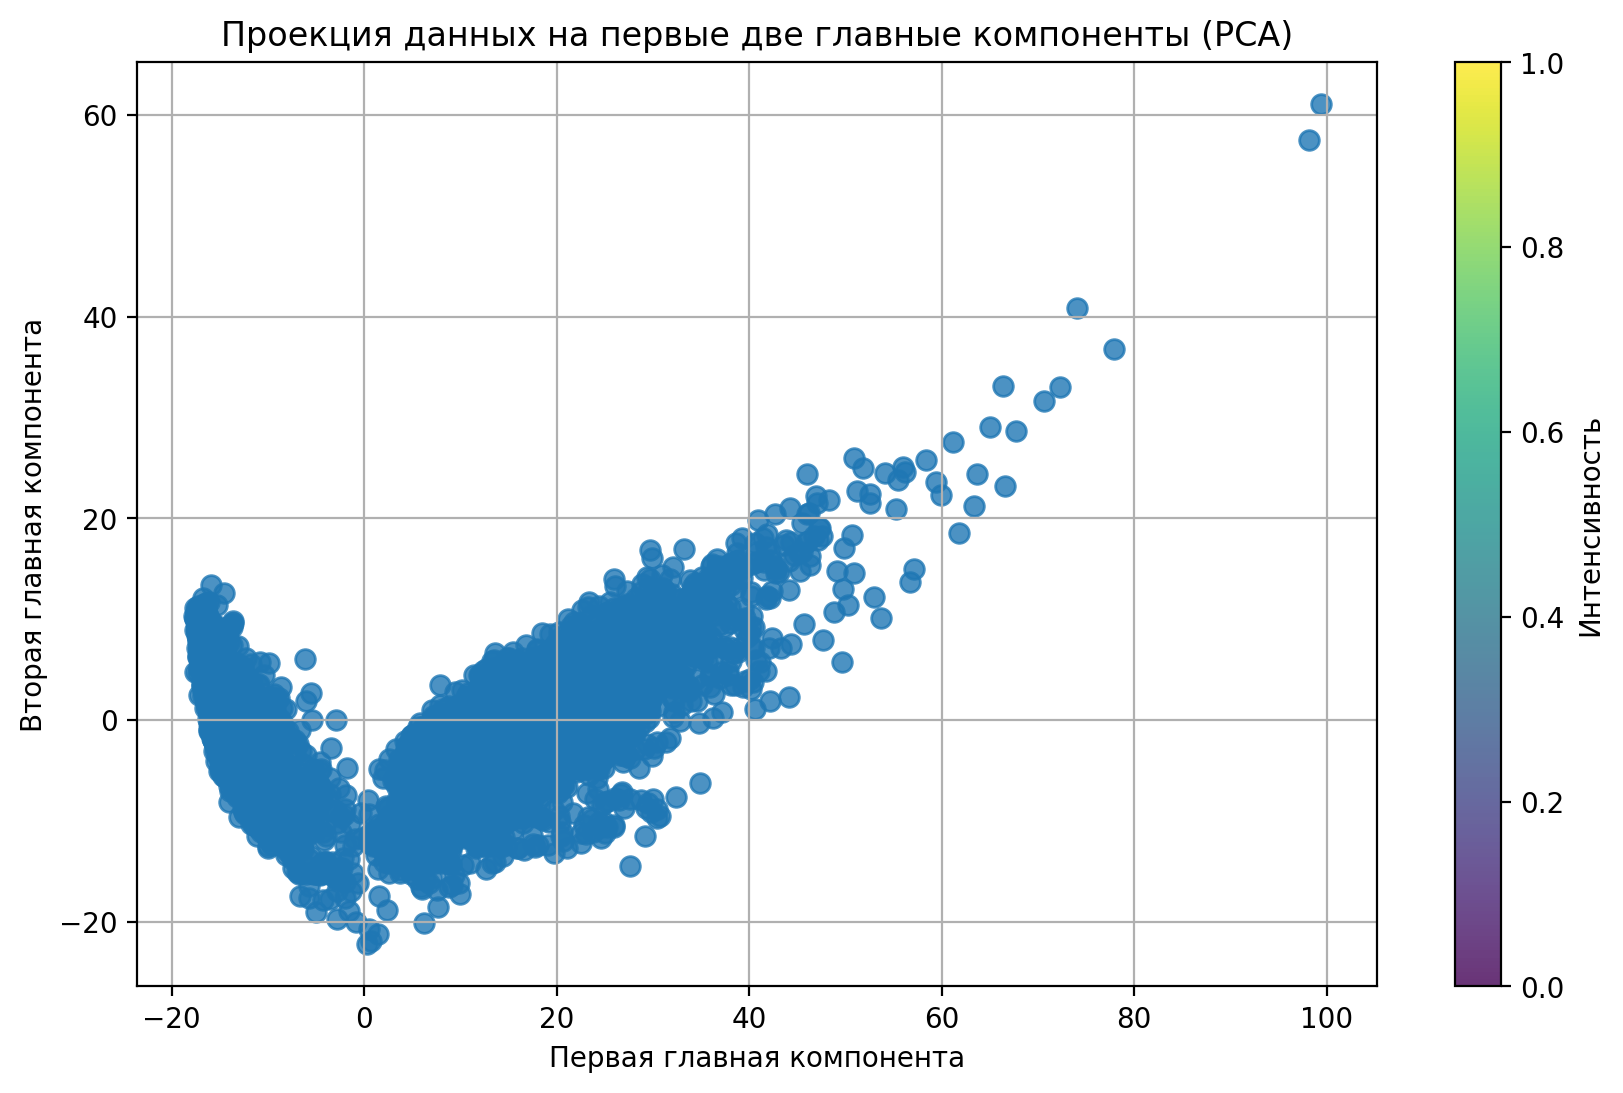

In [325]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Интенсивность')
plt.title('Проекция данных на первые две главные компоненты (PCA)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [326]:
from sklearn.cluster import KMeans

In [327]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=42)

# время обучения
training_start_time = time.time()
kmeans.fit(X_pca)
training_time = time.time() - training_start_time

# время инференса
inference_start_time = time.time()
labels = kmeans.predict(X_pca)
inference_time = time.time() - inference_start_time

print(f"Время обучения: {training_time} секунд")
print(f"Время инференса: {inference_time} секунд")

# метки кластеров
print(f"Метки кластеров: {labels}")

Время обучения: 15.105422973632812 секунд
Время инференса: 0.012655973434448242 секунд
Метки кластеров: [2 2 2 ... 3 3 3]


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

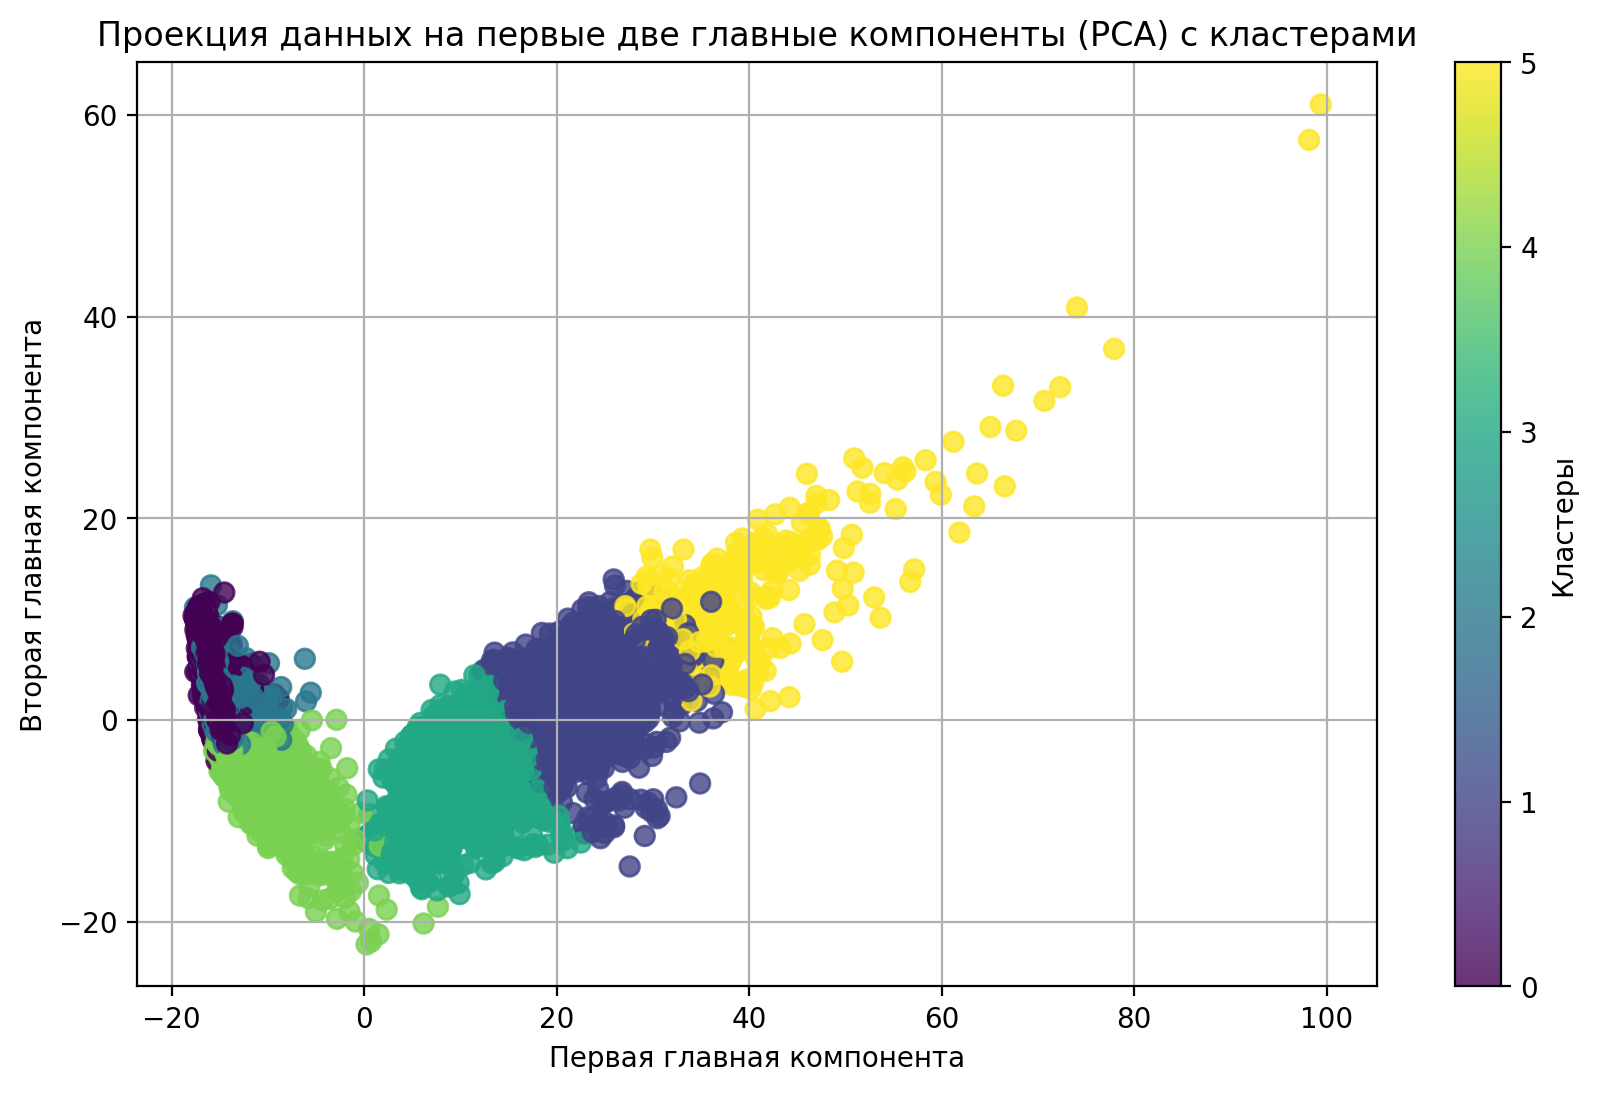

In [328]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Кластеры')
plt.title('Проекция данных на первые две главные компоненты (PCA) с кластерами')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

    Будем оценивать по V-measure (как критерий для знания реальных меток) и Silhouette Score (как показатель разделимости кластеров)

In [329]:
from sklearn.metrics import silhouette_score, v_measure_score

In [330]:
print(f"Silhouette Score: {silhouette_score(X_pca, labels)}")
print(f"V-Measure: {v_measure_score(y[0].values, labels)}")

Silhouette Score: 0.14149759467581455
V-Measure: 0.5600410921019029


Кластеры плохо разделимы (по силуэту), а кластеры лишь частично соответствуют истинным меткам (по V-score)

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [331]:
from sklearn.cluster import AgglomerativeClustering

Время обучения: 1.4498 секунд
Время инференса: 1.4169 секунд


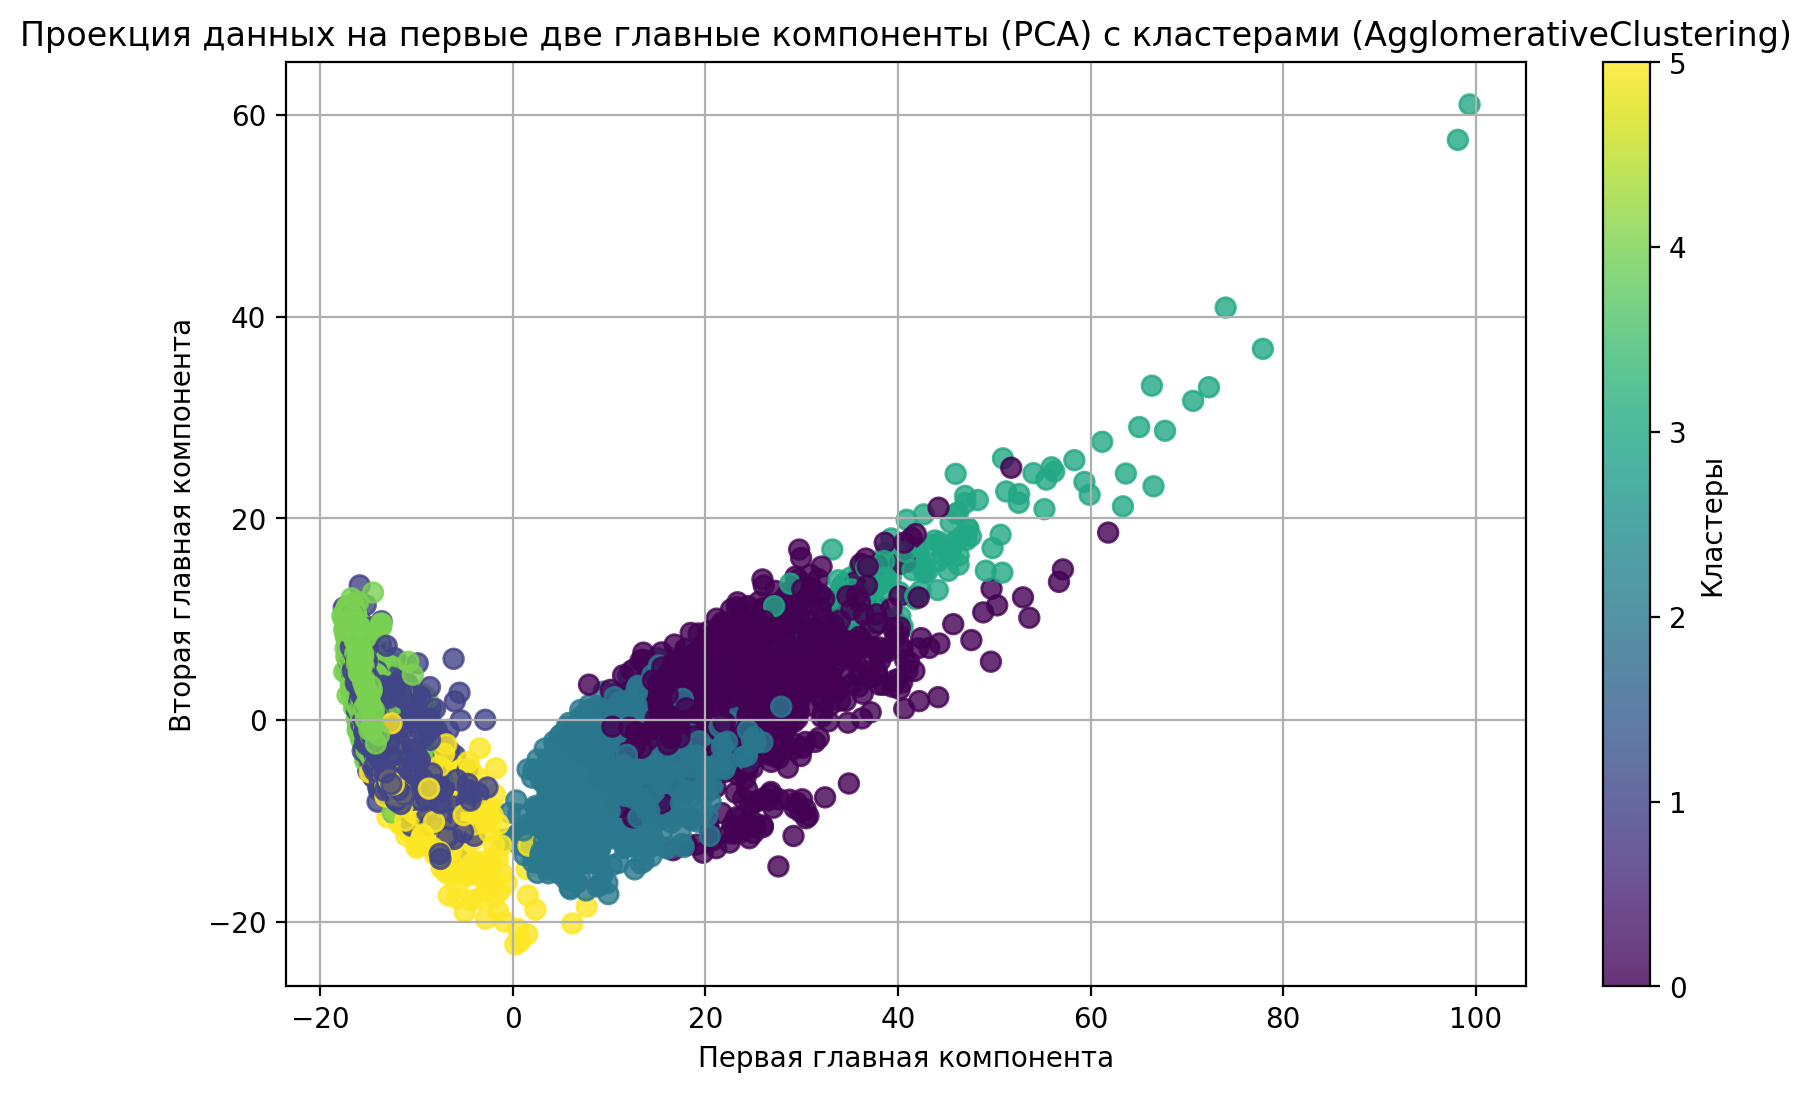

In [332]:
agg_clustering = AgglomerativeClustering(n_clusters=6)

# время обучения
start_time = time.time()
agg_clustering.fit(X_pca)  # Обучение модели
training_time = time.time() - start_time
print(f"Время обучения: {training_time:.4f} секунд")

# время инференса
start_time = time.time()
clusters = agg_clustering.fit_predict(X_pca)  # Предсказание меток
inference_time = time.time() - start_time
print(f"Время инференса: {inference_time:.4f} секунд")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Кластеры')
plt.title('Проекция данных на первые две главные компоненты (PCA) с кластерами (AgglomerativeClustering)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

In [333]:
print(f"Silhouette Score: {silhouette_score(X_pca, clusters)}")
print(f"V-Measure: {v_measure_score(y[0].values, clusters)}")

Silhouette Score: 0.1365817987962443
V-Measure: 0.6217855076000528


**Так как Kmeans пытается сделать кластеры круглыми областями, при нем метрика разделимости была лучше.** \
**При этом качество самой кластеризации по известным значениям стало лучше (с 56% до 62%)**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Без знания признаков, тяжело сказать, насколько типы активности похож на кластер, но заметен самый отдаленый кластер (в правом верхнем углу графика) - скорее всего это лежание, так как его проще всего отличить.** \
**А среди замешанных, думаю, находятся ходьба, подъем и спуск по лестнице - это довольно похожие действия, поэтому они смешаны**
**По качеству, мы конечно не угадываем, но качество довольно слабое. Думаю, в самой разметке с телефона нет сильных признаков, по которым можно было бы с хорошей уверенностью отличать подъем и спуск по лестнице например.**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [334]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [335]:
def find_components(image, lmbd, n_clusters):
    #your code here

SyntaxError: incomplete input (1481975782.py, line 2)

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

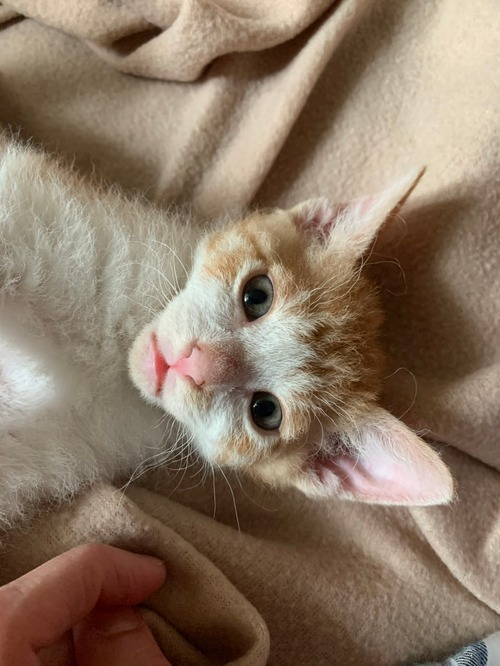